In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import ipywidgets as widgets
from IPython.display import display
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import numpy as np
import plotly.figure_factory as ff
import plotly.offline as pyo
from chart_studio.plotly import plot, iplot
import chart_studio.plotly as py
import plotly.io as pio
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import datetime
from datetime import datetime
from matplotlib import gridspec
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import statsmodels.api as sm
from matplotlib.colors import to_rgba
from matplotlib.patches import Patch

In [12]:
# Read the datasets
student_covid = pd.read_csv('student_covid.csv')
non_student_covid = pd.read_csv('non_student_covid.csv')
student_flu = pd.read_csv('student_flu.csv')
non_student_flu = pd.read_csv('non_student_flu.csv')
safegraph = pd.read_csv('safegraph.csv')
weather = pd.read_csv('weather.csv')
psu_cal = pd.read_csv('psu_calendar.csv')
avg_behavior = pd.read_csv('avg_behaviors_equal_intervals.csv')
ridit = pd.read_csv('ridit.csv')
risk_action = pd.read_csv('risk_action.csv')
behavior_c = pd.read_csv('behavior_c.csv')
behavior_s = pd.read_csv('behavior_s.csv')

# Convert date columns to proper data types
student_flu['Date'] = pd.to_datetime(student_flu['Date'])
non_student_flu['Date'] = pd.to_datetime(non_student_flu['Date'])
psu_cal['end'] = pd.to_datetime(psu_cal['end'], utc=True)
psu_cal['start'] = pd.to_datetime(psu_cal['start'], utc=True)
student_covid['Start date'] = pd.to_datetime(student_covid['Start date'], 
                                             format='%Y-%m-%d')
non_student_covid['Start date'] = pd.to_datetime(non_student_covid['Start date'], 
                                                 format='%Y-%m-%d')
weather['Date'] = pd.to_datetime(weather['Date'])
safegraph['Date'] = pd.to_datetime(safegraph['Date'], format='%m/%d/%Y')

### Figure 1b

#### COVID-19

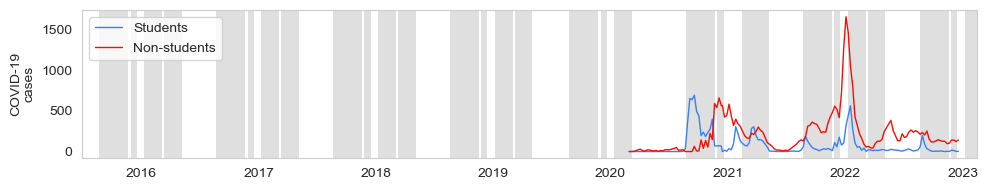

In [9]:
fig, ax = plt.subplots(figsize=(10, 2))

label_size = 10
title_size = 12

# Plot the data for PSU students
ax.plot(student_covid['Start date'], student_covid['Weekly New Cases'], 
        label='PSU students', color='#3781f0', linewidth=1)
# Plot the data for Centre non-students
ax.plot(non_student_covid['Start date'], non_student_covid['Weekly New Cases'], 
        label='Centre w/o PSU students', color='#fc0b03', linewidth=1)

ax.set_xlim(pd.Timestamp('2015-07-01'), pd.Timestamp('2023-02-15'))
ax.tick_params(axis='both', which='both', labelsize=5)
legend_labels = ['Students', 'Non-students']
ax.legend(legend_labels, fontsize=label_size, loc='upper left')
ax.set_xlabel('', fontsize=label_size)
ax.set_title('', fontsize=title_size)
ax.set_ylabel('COVID-19\ncases', fontsize=label_size)
ax.tick_params(axis='both', which='both', labelsize=label_size)

# PSU calendar
for idx, row in psu_cal[psu_cal['students_present'] == 1].iterrows():
    ax.axvspan(row['start'], row['end'], color='gray', alpha=0.25, lw=0)

# Show the plot
plt.tight_layout()
plt.show()

#### Influenza

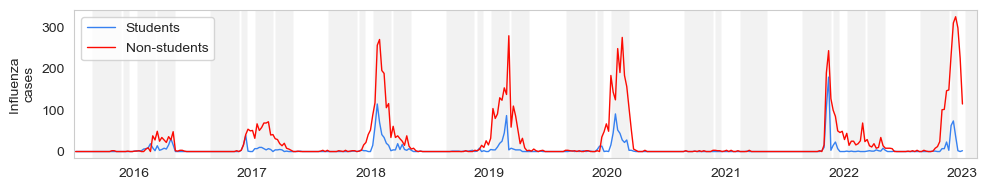

In [10]:
fig, ax = plt.subplots(figsize=(10, 2))

label_size = 10
title_size = 12

# Plot the data for PSU students
ax.plot(student_flu['Date'], student_flu['Weekly New Cases'], 
        label='Students', color="#3781f0", linewidth=1)

# Plot the data for non-students
ax.plot(non_student_flu['Date'], non_student_flu['Weekly New Cases'], 
        label='Non-students', color="#fc0b03", linewidth=1)

ax.set_xlim(pd.Timestamp('2015-07-01'), pd.Timestamp('2023-02-15'))
ax.legend(legend_labels, fontsize=label_size, loc='upper left')
ax.set_xlabel('', fontsize=label_size)
ax.set_title('', fontsize=title_size)
ax.set_ylabel('Influenza \ncases', fontsize=label_size)
ax.tick_params(axis='both', which='both', labelsize=label_size)

# PSU calendar
for idx, row in psu_cal[psu_cal['students_present'] == 1].iterrows():
    ax.axvspan(row['start'], row['end'], facecolor="gray", alpha=0.1)

plt.tight_layout()
plt.show()

### Figure 2

In [13]:
# Label behaviors by type: Protective, Risk, or Protective/Risky (n).
mask = behavior_c['Behavior'] == 'Ate outdoors at restaurants'
behavior_c.loc[mask, 'Behavior type'] = 'Protective/Risky'
mask = behavior_c['Behavior'] == 'Attended outdoor social gatherings'
behavior_c.loc[mask, 'Behavior type'] = 'Protective/Risky'

mask = behavior_s['Behavior'] == 'Ate outdoors at restaurants'
behavior_s.loc[mask, 'Behavior type'] = 'Protective/Risky'
mask = behavior_s['Behavior'] == 'Attended outdoor social gatherings'
behavior_s.loc[mask, 'Behavior type'] = 'Protective/Risky'

cols_n = ['Ate outdoors at restaurants', 'Attended outdoor social gatherings']

cols_p = ['Washed my hands', 'Tried not to touch my eyes', 
          'Covered my mouth when sneezed', 'Stayed home if I felt unwell',
          'Maintained 6 feet', 'Wore a facemask', 
          'Reduced trips outside the house', 'Grocery shop less frequently',
          'Reduced trips to retail locations', 'Attended class/work remotely', 
          'Less frequently attended social gatherings',
          'Avoided large social gatherings']

cols_r = ['Ate indoors at restaurants', 'Attended indoor social gatherings',
          'Attended a concert', 'Attended a sporting event', 
          'Attended a 20-50 people social gathering',
          'Attended a 51-1000 people social gathering', 
          'Attended a 1001-5000 people social gathering', 
          'Attended a >5000 people social gathering']

# study timeframes
behavior_s.set_index('Behavior', inplace=True)
behavior_s.rename({'2020-03-01 to 2021-02-28':'T1', 
                    '2021-05-01 to 2021-08-23':'T2', 
                    '2021-08-24 to 2021-12-18':'T3', 
                    '2022-08-01 to 2022-12-31':'T4'}, axis=1, inplace=True)
behavior_c.set_index('Behavior', inplace=True)
behavior_c.rename({'2020-03-01 to 2021-02-28':'T1', 
                    '2021-05-01 to 2021-12-18':'T2', 
                    '2021-12-19 to 2022-04-29':'T3', 
                    '2022-08-01 to 2022-12-31':'T4'}, axis=1, inplace=True)

C:\Users\bzn5190\AppData\Local\Temp\ipykernel_28392\3316118991.py:113: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



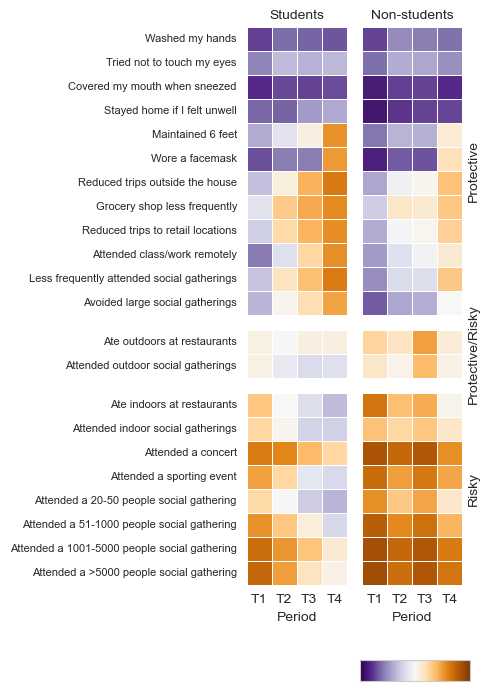

In [16]:
# Student and non-student heatmap
fig = plt.figure(figsize=(5, 7))
subplot_proportions = {'height_ratios': [2.1, .35, 1.4]}
sns.set_style("whitegrid", {'axes.grid': False})
cmap_p = 'PuOr'
cmap_r = 'PuOr_r'
title_size = 10
ticksize = 8

# Define the GridSpec with height ratios
gs = gridspec.GridSpec(3, 2, height_ratios=subplot_proportions['height_ratios'])

# Student subplots
ax1 = plt.subplot(gs[0, 0])
p = behavior_s.loc[behavior_s['Behavior type'] == 'Protective', 
                   behavior_s.columns[:-2]]
p.drop({'Behavior type'}, axis=1, inplace=True)
p = p.stack().reset_index()
p.columns = ['Behavior', 'period', 'behavior_index']
p = p.pivot(columns='period', index='Behavior', values='behavior_index')
p = p.reindex(cols_p)
h1 = sns.heatmap(p, annot=False, fmt=".2f", linewidths=.5, cbar=False, 
                 xticklabels=False, cmap=cmap_p, vmin=0, vmax=4)
plt.ylabel('', fontsize=title_size)
plt.yticks(fontsize=ticksize, rotation=0)
plt.xlabel('', fontsize=title_size)
plt.title('Students', fontsize=title_size)

ax2 = plt.subplot(gs[1, 0])
n = behavior_s.loc[behavior_s['Behavior type'] == 'Protective/Risky', 
                   behavior_s.columns[:-2]]
n.drop({'Behavior type'}, axis=1, inplace=True)
n = n.stack().reset_index()
n.columns = ['Behavior', 'period', 'behavior_index']
n = n.pivot(columns='period', index='Behavior', values='behavior_index')
n = n.reindex(cols_n)
h2 = sns.heatmap(n, annot=False, fmt=".2f", linewidths=.5, cbar=False, 
                 xticklabels=False, cmap=cmap_p, vmin=0, vmax=4)
plt.ylabel('', fontsize=title_size)
plt.yticks(fontsize=ticksize, rotation=0)
plt.xlabel('', fontsize=title_size)
plt.title('', fontsize=title_size)

ax3 = plt.subplot(gs[2, 0])
r = behavior_s.loc[behavior_s['Behavior type'] == 'Risky', 
                   behavior_s.columns[:-2]]
r.drop({'Behavior type'}, axis=1, inplace=True)
r = r.stack().reset_index()
r.columns = ['Behavior', 'period', 'behavior_index']
r = r.pivot(columns='period', index='Behavior', values='behavior_index')
r = r.reindex(cols_r)
h3 = sns.heatmap(r, annot=False, fmt=".2f", linewidths=.5, cbar=False, 
                 xticklabels=True, yticklabels=True, cmap=cmap_p, vmin=0, vmax=4)
plt.ylabel('', fontsize=title_size)
plt.xlabel('Period', fontsize=title_size)
plt.yticks(fontsize=ticksize, rotation=0)
plt.title('', fontsize=title_size)

# non-student subplots
ax4 = plt.subplot(gs[0, 1])
p = behavior_c.loc[(behavior_c['Behavior type'] == 'Protective'), 
                   [h for h in behavior_c.columns if ('rural' not in h) and 
                    ('urban' not in h) and ('Type' not in h)]]
p.drop({'Behavior type'}, axis=1, inplace=True)
p = p.apply(pd.to_numeric, errors='coerce')
p = p.reindex(cols_p)
h4 = sns.heatmap(p, annot=False, fmt=".2f", linewidths=.5, cbar=False, 
                 cmap=cmap_p, xticklabels=False, yticklabels=False, vmin=0, vmax=4)
plt.ylabel('Protective', fontsize=title_size)
ax4.yaxis.set_label_position("right")
plt.xlabel('')
plt.yticks(fontsize=ticksize, rotation=0)
plt.title('Non-students', fontsize=title_size)

ax5 = plt.subplot(gs[1, 1])
n = behavior_c.loc[(behavior_c['Behavior type'] == 'Protective/Risky'), 
                   [h for h in behavior_c.columns if ('rural' not in h) 
                    and ('urban' not in h) and ('Type' not in h)]]
n.drop({'Behavior type'}, axis=1, inplace=True)
n = n.apply(pd.to_numeric, errors='coerce')
n = n.reindex(cols_n)
h5 = sns.heatmap(n, annot=False, fmt=".2f", linewidths=.5, cbar=False, 
                 cmap=cmap_p, xticklabels=False, yticklabels=False, vmin=0, vmax=4)
plt.ylabel('Protective/Risky', fontsize=title_size)
ax5.yaxis.set_label_position("right")
plt.xlabel('')
plt.yticks(fontsize=ticksize, rotation=0)
plt.title('', fontsize=title_size)

ax6 = plt.subplot(gs[2, 1])
r = behavior_c.loc[(behavior_c['Behavior type'] == 'Risky'), 
                   [h for h in behavior_c.columns if ('rural' not in h) 
                    and ('urban' not in h) and ('Type' not in h)]]
r.drop({'Behavior type'}, axis=1, inplace=True)
r = r.apply(pd.to_numeric, errors='coerce')
r = r.reindex(cols_r)
h6 = sns.heatmap(r, annot=False, fmt=".2f", linewidths=.5, cbar=False, 
                 cmap=cmap_p, yticklabels=False, xticklabels=True, vmin=0, vmax=4)
plt.ylabel('Risky', fontsize=title_size)
ax6.yaxis.set_label_position("right")
plt.xlabel('Period', fontsize=title_size)
plt.yticks(fontsize=ticksize, rotation=0)
plt.title('')

cbar_ax1 = fig.add_axes([.73, .02, .22, 0.03])  # Left, Bottom, Width, Height

sm1 = ScalarMappable(cmap=cmap_r, norm=plt.Normalize(vmin=0, vmax=4))
sm1.set_array([])
cbar1 = plt.colorbar(sm1, cax=cbar_ax1, orientation='horizontal')
cbar1.set_label('')
cbar1.set_ticks([])
cbar1.set_ticklabels([])

plt.tight_layout(rect=[0, .08, 1, 1])
plt.show()

C:\Users\bzn5190\AppData\Local\Temp\ipykernel_28392\2279247036.py:58: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



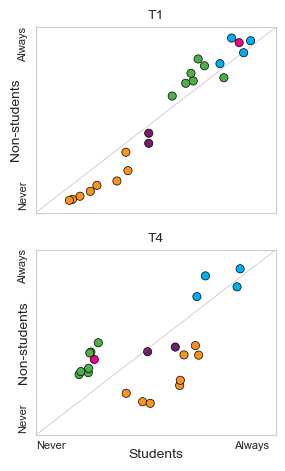

In [18]:
fig = plt.figure(figsize=(3, 6))
sns.set_style("whitegrid", {'axes.grid': False})
fig.subplots_adjust(wspace=10)
cmap = "Set3"

colors = {'Cluster1': '#00aeef',
          'Cluster2': '#ec008c',
          'Cluster3': '#4eaf49',
          'Cluster4': '#751c6d',
          'Cluster5': '#f7941d',
                }

title_size = 10
ticksize = 8

plt.subplot(2, 1, 1)
s = behavior_s.loc[:,['Behavior type', 'Type5', 'T1']]
s.rename({'T1':'T1 student'}, axis=1, inplace=True)
c = behavior_c.loc[:,['Behavior type', 'Type5', 'T1']]
c.rename({'T1':'T1 non-student'}, axis=1, inplace=True)
a = pd.concat([s, c['T1 non-student']], axis=1)
p = a[a['Behavior type']=='Protective']
r = a[a['Behavior type']=='Risky']
n = a[a['Behavior type']=='Protective/Risky']

sns.scatterplot(x=a['T1 student'],
                y=a['T1 non-student'],
                marker='o', color=a['Type5'].map(colors), 
                s=35,edgecolor="black",linewidth=.5,
                legend=False)

sns.lineplot(x=[0, 4], y=[0, 4], alpha=.5, linewidth=0.5, color='gray')
plt.xlabel("", fontsize=title_size, labelpad=10)
plt.ylabel("Non-students", fontsize=title_size, labelpad=10)
plt.xlim(0, 4)
plt.ylim(0, 4)
plt.title("T1", fontsize=title_size)
plt.yticks(fontsize=ticksize, rotation=0)


plt.tick_params(axis='both', which='both', bottom=False, top=False, 
                left=False, right=False, labelbottom=False,
                labelleft=False)

plt.text(-.3, .1, 'Never', fontsize=ticksize, rotation=90)
plt.text(-.3, 3.3, 'Always', fontsize=ticksize, rotation=90)

plt.subplot(2, 1, 2)
s = behavior_s.loc[:,['Behavior type', 'Type5', 'T4']]
s.rename({'T4':'T4 student'}, axis=1, inplace=True)
c = behavior_c.loc[:,['Behavior type', 'Type5', 'T4']]
c.rename({'T4':'T4 non-student'}, axis=1, inplace=True)
a = pd.concat([s, c['T4 non-student']], axis=1)
p = a[a['Behavior type']=='Protective']
r = a[a['Behavior type']=='Risky']
n = a[a['Behavior type']=='Protective/Risky']

sns.scatterplot(x=a['T4 student'],
                y=a['T4 non-student'],
                marker='o', color=a['Type5'].map(colors), s=35, 
                edgecolor="black",linewidth=0.5,
                legend=False, palette=cmap)

sns.lineplot(x=[0, 4], y=[0, 4], alpha=.5, linewidth=0.5, color='gray')
plt.xlabel("Students", fontsize=title_size, labelpad=10)
plt.ylabel("Non-students", fontsize=title_size)
plt.xlim(0, 4)
plt.ylim(0, 4)
plt.title("T4", fontsize=title_size)
plt.xticks(fontsize=ticksize, rotation=0)

plt.tick_params(axis='both', which='both', bottom=False, top=False, 
                left=False, right=False, labelbottom=False, labelleft=False)

plt.text(3.3, -.3, 'Always', fontsize=ticksize, rotation=0)
plt.text(0, -.3, 'Never', fontsize=ticksize, rotation=0)
plt.text(-.3, .1, 'Never', fontsize=ticksize, rotation=90)
plt.text(-.3, 3.3, 'Always', fontsize=ticksize, rotation=90)

plt.subplots_adjust(bottom=.2, right=.9, left=.1)
plt.show()

### Figure 3

In [19]:
# Prepare features for clustering
behavior_s['ch1'] = behavior_s['T2'] - behavior_s['T1']
behavior_s['ch2'] = behavior_s['T3'] - behavior_s['T2']
behavior_s['ch3'] = behavior_s['T4'] - behavior_s['T3']
behavior_s['Protective'] = pd.get_dummies(
    behavior_s['Behavior type'])['Protective'].astype(int)

behavior_c['ch1'] = behavior_c['T2'] - behavior_c['T1']
behavior_c['ch2'] = behavior_c['T3'] - behavior_c['T2']
behavior_c['ch3'] = behavior_c['T4'] - behavior_c['T3']
behavior_c['Protective'] = pd.get_dummies(
    behavior_c['Behavior type'])['Protective'].astype(int)


#### 7 Cluster

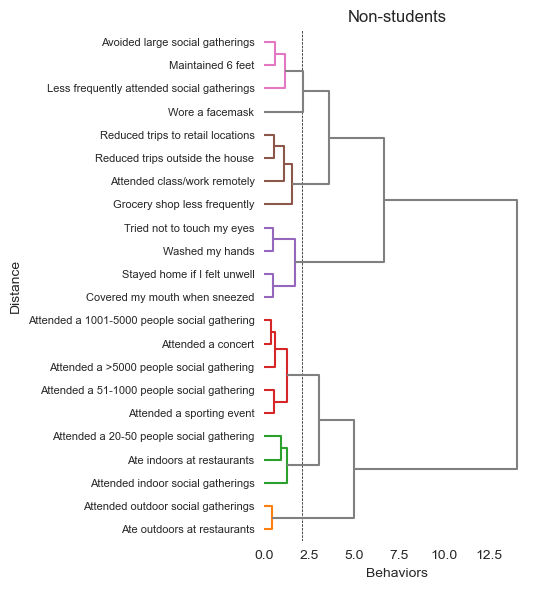

In [20]:
# Non-student
behavior_c7 = behavior_c[['ch1', 'ch2', 'ch3', 'T1', 'T2', 'T3', 'T4']].copy()

# Normalize the data
scaler = StandardScaler()
behavior_c7_normalized = scaler.fit_transform(behavior_c7)

linked = linkage(behavior_c7_normalized, method='ward', metric='euclidean')
clusters = fcluster(linked, 7, criterion='maxclust')
behavior_c7['clusters'] = clusters
behavior_c7['change'] = (behavior_c7.loc[:,['T1', 'T2', 'T3', 'T4']].max(axis=1) - 
                         behavior_c7.loc[:,['T1', 'T2', 'T3', 'T4']].min(axis=1))
behavior_c7['cohort'] = 'Non-student'

labels = behavior_c7.index

def custom_leaf_label_func(id):
    if id < len(labels):
        return labels[id]
    else:
        return f'Cluster {clusters[id - len(labels)]}'

plt.figure(figsize=(5.5, 6))

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.axvline(x=2.1, color='black', linestyle='--', linewidth=.5)

dendrogram(linked, leaf_rotation=90, orientation='right', leaf_font_size=8, 
           above_threshold_color='gray', color_threshold=2.1, 
           leaf_label_func=custom_leaf_label_func)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
plt.title('Non-students')
plt.xlabel('Behaviors')
plt.ylabel('Distance')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

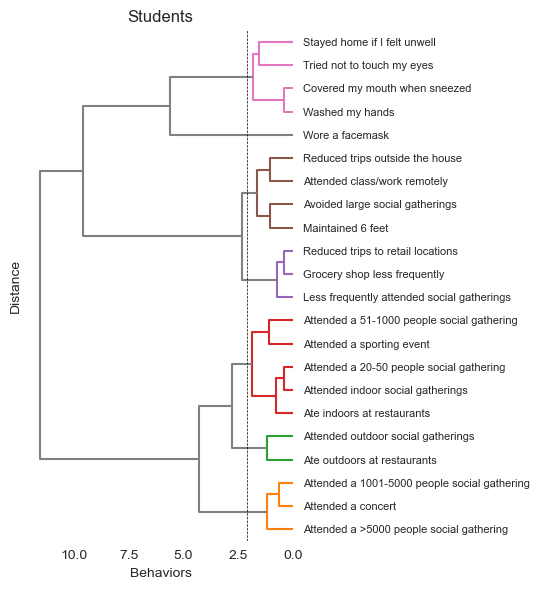

In [21]:
# Student
behavior_s7 = behavior_s[['ch1', 'ch2', 'ch3', 'T1', 'T2', 'T3', 'T4']].copy()

# Normalize the data
scaler = StandardScaler()
behavior_s7_normalized = scaler.fit_transform(behavior_s7)

linked = linkage(behavior_s7_normalized, method='ward', metric='euclidean')
clusters = fcluster(linked, 7, criterion='maxclust')
behavior_s7['clusters'] = clusters
behavior_s7['change'] = (behavior_s7.loc[:,['T1', 'T2', 'T3', 'T4']].max(axis=1) - 
                         behavior_s7.loc[:,['T1', 'T2', 'T3', 'T4']].min(axis=1))
behavior_s7['cohort'] = 'Student'
color_palette = sns.color_palette("hls", 7)

labels = behavior_s7.index

def custom_leaf_label_func(id):
    if id < len(labels):
        return labels[id]
    else:
        return f'Cluster {clusters[id - len(labels)]}'

plt.figure(figsize=(5.5, 6))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
dendrogram(linked, leaf_rotation=90, orientation='left', leaf_font_size=8, 
           above_threshold_color='gray', color_threshold=2.1, 
           leaf_label_func=custom_leaf_label_func)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
plt.title('Students')
plt.xlabel('Behaviors')
plt.ylabel('Distance')
plt.yticks(rotation=0)
plt.tight_layout()
plt.axvline(x=2.1, color='black', linestyle='--', linewidth=.5)
plt.show()

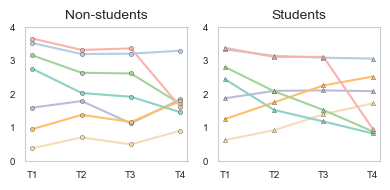

In [22]:
# Cluster trajectories
bs = behavior_s7[['clusters', 'T1', 'T2', 'T3', 'T4']].groupby(
    ['clusters']).mean().reset_index()
bc = behavior_c7[['clusters', 'T1', 'T2', 'T3', 'T4']].groupby(
    ['clusters']).mean().reset_index()

non_student_colors = {1: '#BEBAD9', 2: '#FDBF6A', 3: '#F5DCB9', 
                      4: '#B3CDE2', 5: '#8ED1C6', 6: '#A2D39A', 7: '#F9B3AE'}
student_colors = {1: '#F5DCB9', 2: '#BEBAD9', 3: '#FDBF6A', 
                  4: '#8ED1C6', 5: '#A2D39A', 6: '#B3CDE2', 7: '#F9B3AE'}

fig, axs = plt.subplots(1, 2, figsize=(4, 2))

# Plot for non-students
axs[0].set_prop_cycle(color=[non_student_colors[i] for i in bc['clusters']])
for i, row in bc.iterrows():
    cluster_label = f'Cluster {row["clusters"]}'
    axs[0].plot(row.index[1:], row.values[1:], label=cluster_label, 
                marker='o', markersize=3, markeredgecolor='black', markeredgewidth=.2)

for item in ([axs[0].xaxis.label, axs[0].yaxis.label] + 
             axs[0].get_xticklabels() + 
             axs[0].get_yticklabels() + 
             [axs[0].title]):
    item.set_fontsize(7)
    
axs[0].set_title("Non-students", fontsize=title_size)

axs[0].set_ylim([0, 4])

# Plot for Students
axs[1].set_prop_cycle(color=[student_colors[i] for i in bs['clusters']])
for i, row in bs.iterrows():
    cluster_label = f'Cluster {row["clusters"]}'
    axs[1].plot(row.index[1:], row.values[1:], label=cluster_label, marker='^', 
                markersize=3, markeredgecolor='black', markeredgewidth=.2)

for item in ([axs[1].xaxis.label, axs[1].yaxis.label] + 
             axs[1].get_xticklabels() + 
             axs[1].get_yticklabels() + 
             [axs[1].title]):
    item.set_fontsize(7)
axs[1].set_title("Students", fontsize=title_size)

axs[1].set_ylim([0, 4])
plt.tight_layout()
plt.show()

#### 4 cluster

Number of clusters: 2, Silhouette Score: 0.5484698587577771
Number of clusters: 3, Silhouette Score: 0.554792521923492
Number of clusters: 4, Silhouette Score: 0.5603406905784438
Number of clusters: 5, Silhouette Score: 0.5212859534214775
Number of clusters: 6, Silhouette Score: 0.5012985795075907
Number of clusters: 7, Silhouette Score: 0.47725117096127545
Number of clusters: 8, Silhouette Score: 0.4719629000809831
Number of clusters: 9, Silhouette Score: 0.44703055642638495
Number of clusters: 10, Silhouette Score: 0.3958450311686135

Optimal number of clusters: 4, Best Silhouette Score: 0.5603406905784438


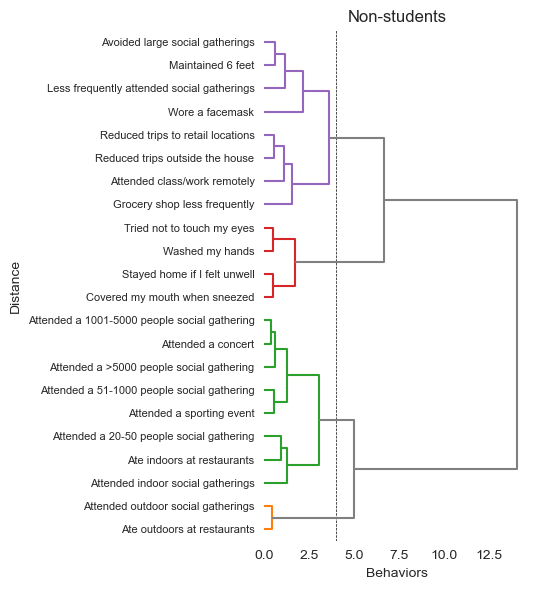

In [27]:
# non-students
behavior_c4 = behavior_c[['ch1', 'ch2', 'ch3', 'T1', 'T2', 'T3', 'T4']].copy()

# Normalize the data
scaler = StandardScaler()
behavior_c4_normalized = scaler.fit_transform(behavior_c4)

# Use silhouette method to find the optimal number of clusters
silhouette_scores = []
for n_clusters in range(2, 11):
    linked = linkage(behavior_c4_normalized, method='ward', metric='euclidean')
    clusters = fcluster(linked, n_clusters, criterion='maxclust')
    silhouette_avg = silhouette_score(behavior_c4_normalized, clusters)
    silhouette_scores.append(silhouette_avg)

optimal_num_clusters = np.argmax(silhouette_scores) + 2

# Print silhouette scores and corresponding number of clusters
for n_clusters, silhouette_s in enumerate(silhouette_scores, start=2):
    print(f'Number of clusters: {n_clusters}, Silhouette Score: {silhouette_s}')

print(f'\nOptimal number of clusters: {optimal_num_clusters}, Best Silhouette Score: {max(silhouette_scores)}')

distance_threshold = 0 

# Cluster with the optimal number of clusters
linked = linkage(behavior_c4_normalized, method='ward', metric='euclidean')
clusters = fcluster(linked, 4, criterion='maxclust')
behavior_c4['clusters'] = clusters
behavior_c4['change'] = (behavior_c4.loc[:,['T1', 'T2', 'T3', 'T4']].max(axis=1) - 
                         behavior_c4.loc[:,['T1', 'T2', 'T3', 'T4']].min(axis=1))
behavior_c4['cohort'] = 'Non-student'
color_palette = sns.color_palette("hls", optimal_num_clusters)

labels = behavior_c4.index

def custom_leaf_label_func(id):
    if id < len(labels):
        return labels[id]
    else:
        return f'Cluster {clusters[id - len(labels)]}'

plt.figure(figsize=(5.5, 6))

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.axvline(x=4, color='black', linestyle='--', linewidth=.5)

dendrogram(linked, leaf_rotation=90, orientation='right', leaf_font_size=8, 
           above_threshold_color='gray', color_threshold=4, 
           leaf_label_func=custom_leaf_label_func)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
plt.title('Non-students')

plt.xlabel('Behaviors')
plt.ylabel('Distance')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Number of clusters: 2, Silhouette Score: 0.40287404267730564
Number of clusters: 3, Silhouette Score: 0.539127708251585
Number of clusters: 4, Silhouette Score: 0.5579071403441301
Number of clusters: 5, Silhouette Score: 0.5073939431785567
Number of clusters: 6, Silhouette Score: 0.4558827258083243
Number of clusters: 7, Silhouette Score: 0.3549121802181616
Number of clusters: 8, Silhouette Score: 0.33483922780873054
Number of clusters: 9, Silhouette Score: 0.3013146805796625
Number of clusters: 10, Silhouette Score: 0.3089112118357447
Optimal Number of Clusters: 4


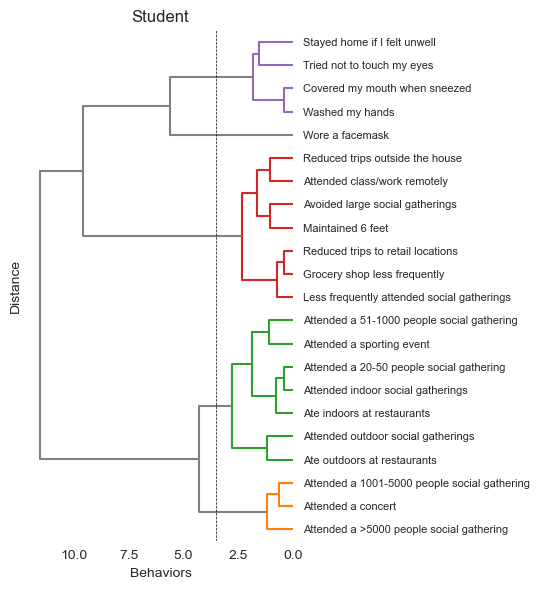

In [29]:
# Students
behavior_s4 = behavior_s[['ch1', 'ch2', 'ch3', 'T1', 'T2', 'T3', 'T4']].copy()

# Normalize the data
scaler = StandardScaler()
behavior_s4_normalized = scaler.fit_transform(behavior_s4)

silhouette_scores = []
for n_clusters in range(2, 11):
    linked = linkage(behavior_s4_normalized, method='ward', metric='euclidean')
    clusters = fcluster(linked, n_clusters, criterion='maxclust')
    silhouette_avg = silhouette_score(behavior_s4_normalized, clusters)  # Calculate silhouette score
    silhouette_scores.append(silhouette_avg)

optimal_num_clusters = np.argmax(silhouette_scores) + 2

for n_clusters, silhouette_s in enumerate(silhouette_scores, start=2):
    print(f'Number of clusters: {n_clusters}, Silhouette Score: {silhouette_s}')

print(f"Optimal Number of Clusters: {optimal_num_clusters}")

linked = linkage(behavior_s4_normalized, method='ward', metric='euclidean')
clusters = fcluster(linked, 4, criterion='maxclust')
behavior_s4['clusters'] = clusters
behavior_s4['change'] = behavior_s4.loc[:,['T1', 'T2', 'T3', 'T4']].max(axis=1) - behavior_s4.loc[:,['T1', 'T2', 'T3', 'T4']].min(axis=1)
behavior_s4['cohort'] = 'Students'
color_palette = sns.color_palette("hls", optimal_num_clusters)

labels = behavior_s4.index

def custom_leaf_label_func(id):
    if id < len(labels):
        return labels[id]
    else:
        return f'Cluster {clusters[id - len(labels)]}'

plt.figure(figsize=(5.5, 6))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
dendrogram(linked, leaf_rotation=90, orientation='left', leaf_font_size=8, 
           above_threshold_color='gray', color_threshold=4, 
           leaf_label_func=custom_leaf_label_func)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
plt.title('Student')

plt.xlabel('Behaviors')
plt.ylabel('Distance')
plt.yticks(rotation=0)
plt.tight_layout()
plt.axvline(x=3.5, color='black', linestyle='--', linewidth=.5)
plt.show()

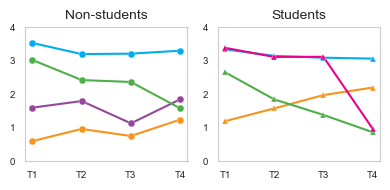

In [31]:
# Behavior trajectories
bs = behavior_s4[['clusters', 'T1', 'T2', 'T3', 'T4']].groupby(
    ['clusters']).mean().reset_index()
bc = behavior_c4[['clusters', 'T1', 'T2', 'T3', 'T4']].groupby(
    ['clusters']).mean().reset_index()

non_student_colors = {1: '#95479B', 2: '#F7941D', 3: '#00AEEF', 4: '#4EAF49'}
student_colors = {1: '#F7941D', 2: '#4EAF49', 3: '#00AEEF', 4: '#EC008C'}

fig, axs = plt.subplots(1, 2, figsize=(4, 2))

# Plot for non-students
axs[0].set_prop_cycle(color=[non_student_colors[i] for i in bc['clusters']])
for i, row in bc.iterrows():
    cluster_label = f'Cluster {row["clusters"]}'
    axs[0].plot(row.index[1:], row.values[1:], label=cluster_label, marker='o', 
                markersize=5, markeredgecolor='white', markeredgewidth=.2)

for item in ([axs[0].xaxis.label, axs[0].yaxis.label] + 
             axs[0].get_xticklabels() + 
             axs[0].get_yticklabels() + 
             [axs[0].title]):
    item.set_fontsize(7)

axs[0].set_ylim([0, 4])
axs[0].set_title("Non-students", fontsize=title_size)

# Plot for Students
axs[1].set_prop_cycle(color=[student_colors[i] for i in bs['clusters']])
for i, row in bs.iterrows():
    cluster_label = f'Cluster {row["clusters"]}'
    axs[1].plot(row.index[1:], row.values[1:], label=cluster_label, 
                marker='^', markersize=5, markeredgecolor='white', markeredgewidth=.2)

for item in ([axs[1].xaxis.label, axs[1].yaxis.label] + 
             axs[1].get_xticklabels() + 
             axs[1].get_yticklabels() + 
             [axs[1].title]):
    item.set_fontsize(7)

axs[1].set_ylim([0, 4])
axs[1].set_title("Students", fontsize=title_size)

plt.tight_layout()
plt.show()

### Figure 4

NameError: name 'cohort' is not defined

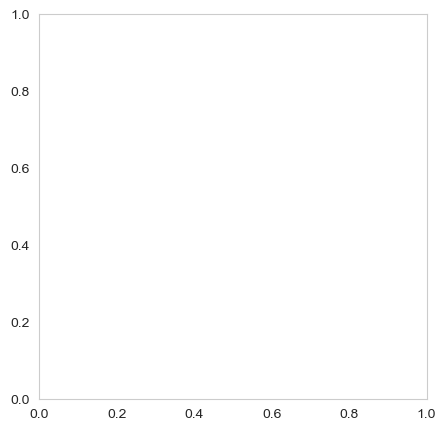

In [32]:
# Students
risk_action_std = risk_action[risk_action['cohort'] == 'Student']

fig, ax = plt.subplots(figsize=(5, 5))
color_mapping = {}  

if cohort == 'Students':
    custom_colors = ['#00aeef', '#4eaf49', '#ec008c', '#f7941d', '#751c6d']
else:
    custom_colors = ['#00aeef', '#4eaf49', '#ec008c', '#f7941d', '#751c6d']

custom_color_index = 0 

for index, row in risk_action_std.iterrows():
    if row['Type4'] not in color_mapping:
        color_mapping[row['Type4']] = to_rgba(custom_colors[custom_color_index])
        custom_color_index = (custom_color_index + 1) % len(custom_colors)

    color = color_mapping[row['Type4']]

    marker_size = 30  
    line_width = 0.5

    ax.arrow(row['Risk_avg_w4'], row['Action_avg_w4'], 
              row['Risk_avg_w5'] - row['Risk_avg_w4'], 
             row['Action_avg_w5'] - row['Action_avg_w4'],
              head_width=0.08, head_length=0.1, fc=color, 
             ec='black', lw=.3, linewidth=0.3, zorder=0)

    ax.scatter(row['Risk_avg_w4'], row['Action_avg_w4'], c=[color], 
               s=marker_size, edgecolor='black', linewidth=0.4, marker='o', 
               facecolors='none')

ax.set_xlabel('Risk perception', fontsize=8)
ax.set_ylabel('Behavior engagement', fontsize=8)
ax.set_title('Students', fontsize=8)
ax.set_xlim(0, 4)
ax.set_ylim(0, 4)

ax.set_xticks(range(5))
ax.set_yticks(range(5))

ax.tick_params(axis='both', which='both', labelsize=7)

ax.grid(True, linewidth=0.3, zorder=-1)
plt.show()


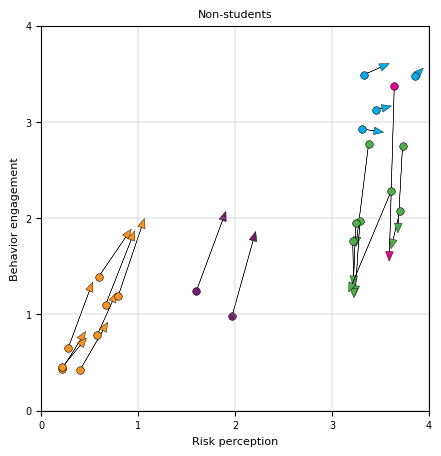

In [102]:
# Non-students
risk_action_std = risk_action[risk_action['cohort'] == 'Non_students']

fig, ax = plt.subplots(figsize=(5, 5))
color_mapping = {} 

if cohort == 'Non_students':
    custom_colors = ['#00aeef', '#4eaf49', '#ec008c', '#f7941d', '#751c6d']
else:
    custom_colors = ['#00aeef', '#4eaf49', '#ec008c', '#f7941d', '#751c6d']

custom_color_index = 0

legend_labels = []
legend_handles = []

for index, row in risk_action_std.iterrows():
    if row['Type4'] not in color_mapping:
        color_mapping[row['Type4']] = to_rgba(custom_colors[custom_color_index])
        custom_color_index = (custom_color_index + 1) % len(custom_colors)

        legend_labels.append(row['Type4'])
        legend_handles.append(Patch(color=color_mapping[row['Type4']], label=row['Type4']))

    color = color_mapping[row['Type4']]

    marker_size = 30 
    line_width = 0.5

    ax.arrow(row['Risk_avg_w4'], row['Action_avg_w4'], 
              row['Risk_avg_w5'] - row['Risk_avg_w4'], row['Action_avg_w5'] - row['Action_avg_w4'],
              head_width=0.08, head_length=0.1, fc=color, ec='black', lw=.3, linewidth=0.3, zorder=0)

    ax.scatter(row['Risk_avg_w4'], row['Action_avg_w4'], c=[color], s=marker_size, edgecolor='black', linewidth=0.4, marker='o', facecolors='none')

ax.set_xlabel('Risk perception', fontsize=8)
ax.set_ylabel('Behavior engagement', fontsize=8)
ax.set_title('Non-students', fontsize=8)
ax.set_xlim(0, 4)
ax.set_ylim(0, 4)

ax.set_xticks(range(5))
ax.set_yticks(range(5))

ax.tick_params(axis='both', which='both', labelsize=7)

ax.grid(True, linewidth=0.3, zorder=-1)
plt.show()

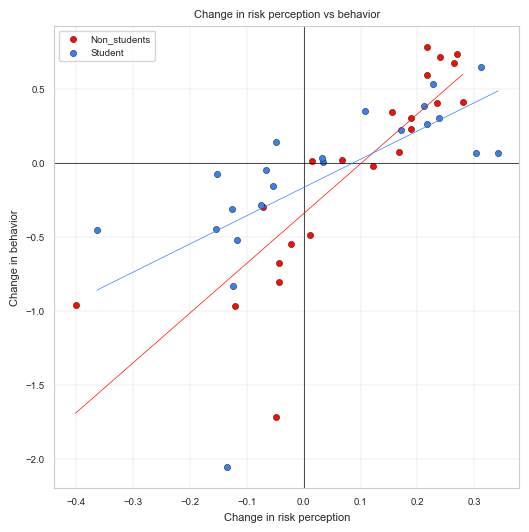

In [33]:
risk_action['d_Risk_avg'] = risk_action['d_Risk_avg'].astype(float)
risk_action['d_Action_avg'] = risk_action['d_Action_avg'].astype(float)

def assign_color(cohort):
    if cohort == "Non_students":
        return "#fc0b03"
    elif cohort == "Student":
        return "#3781f0"
    else:
        return "gray" 

fig, ax = plt.subplots(figsize=(6,6))
for cohort, color in {'Non_students': '#fc0b03', 'Student': '#3781f0'}.items():
    cohort_data = risk_action[risk_action['cohort'] == cohort]
    ax.scatter(cohort_data['d_Risk_avg'], cohort_data['d_Action_avg'], 
               label=cohort, c=color, s=20, edgecolor='black', linewidth=0.3) 

x_regression = []
y_regression = {}
reg_model = {}

ax.set_xlabel('Change in risk perception', fontsize=8)
ax.set_ylabel('Change in behavior', fontsize=8)
ax.set_title('Change in risk perception vs behavior', fontsize=8)
ax.axvline(0, color='black', linewidth=0.5)
ax.axhline(0, color='black', linewidth=0.5)  
ax.grid(True, alpha=0.7, linewidth=0.3)  

ax.tick_params(axis='both', labelsize=7)

for cohort in risk_action['cohort'].unique():
    cohort_data = risk_action[risk_action['cohort'] == cohort]
    X = sm.add_constant(cohort_data['d_Risk_avg'])
    model = sm.OLS(cohort_data['d_Action_avg'], X).fit()
    reg_model[cohort] = model
    x_regression.extend(cohort_data['d_Risk_avg'])
    y_regression[cohort] = model.predict(X)

    point_color = assign_color(cohort)

    sorted_indices = np.argsort(cohort_data['d_Risk_avg'])
    x_sorted = cohort_data['d_Risk_avg'].values[sorted_indices]
    y_sorted = y_regression[cohort].values[sorted_indices]
    ax.plot(x_sorted, y_sorted, color=point_color, linewidth=0.5)

ax.legend(fontsize=7)
plt.show()

#### Students: change in behavior vs. change in risk perception

In [34]:
print(reg_model["Student"].summary())

                            OLS Regression Results                            
Dep. Variable:           d_Action_avg   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     14.26
Date:                Wed, 07 Feb 2024   Prob (F-statistic):            0.00119
Time:                        21:32:58   Log-Likelihood:                -12.388
No. Observations:                  22   AIC:                             28.78
Df Residuals:                      20   BIC:                             30.96
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1663      0.097     -1.720      0.1

#### Non-students: change in behavior vs. change in risk perception

In [35]:
print(reg_model["Non_students"].summary())

                            OLS Regression Results                            
Dep. Variable:           d_Action_avg   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     47.68
Date:                Wed, 07 Feb 2024   Prob (F-statistic):           1.05e-06
Time:                        21:33:02   Log-Likelihood:                -8.6403
No. Observations:                  22   AIC:                             21.28
Df Residuals:                      20   BIC:                             23.46
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3424      0.090     -3.789      0.0

### Figure S1

#### Absolute humidity

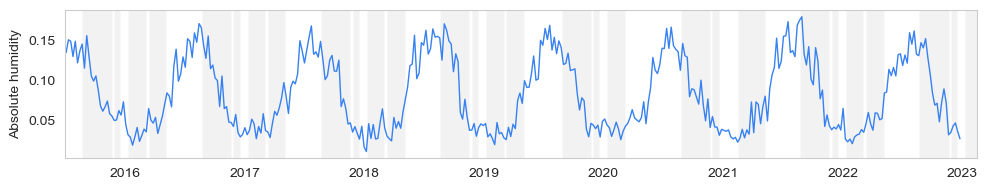

In [36]:
fig, ax = plt.subplots(figsize=(10, 2))

label_size = 10
title_size = 12

ax.plot(weather['Date'], weather['AH'], label='Absolute humidity', 
        color="#3781f0", linewidth=1)
ax.set_xlim(pd.Timestamp('2015-07-01'), pd.Timestamp('2023-02-15'))

# PSU calendar
for idx, row in psu_cal[psu_cal['students_present'] == 1].iterrows():
    ax.axvspan(row['start'], row['end'], facecolor="gray", alpha=0.1)

ax.set_xlabel('', fontsize=label_size)
ax.set_title('', fontsize=title_size)
ax.set_ylabel('Absolute humidity', fontsize=label_size)
ax.tick_params(axis='both', which='both', labelsize=label_size)

plt.tight_layout()
plt.show()

### Figure S2

In [37]:
v_names = ['record_id','Washed my hands', 'Wore a facemask',
           'Tried not to touch my eyes','Covered my mouth when sneezed',
           'Stayed home if I felt unwell','Maintained 6 feet']

#### Students: Ridit

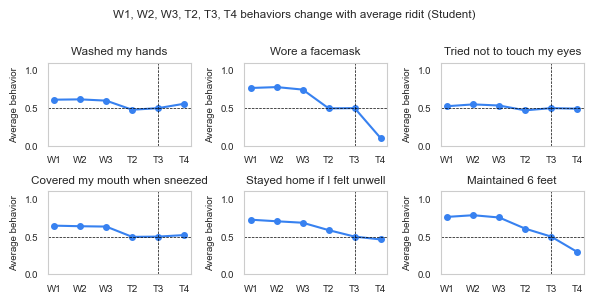

In [38]:
t1 = ridit.loc[ridit['Reference']=='2021-08-23 to 2021-12-18', ]

i = 1
j = 1

plt.rcParams.update({'font.size': 7})
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6, 3))
fig.suptitle('W1, W2, W3, T2, T3, T4 behaviors change with average ridit (Student)')

for v in v_names[1:]:
    aux = t1.loc[t1['Variable']== v, ['Period', 'Avg_ridit']]
    w1 = np.array(aux.loc[aux['Period']=='2020-06-01 to 2020-10-31', 'Avg_ridit'])[0]
    w2 = np.array(aux.loc[aux['Period']=='2020-11-01 to 2021-01-31', 'Avg_ridit'])[0]
    w3 = np.array(aux.loc[aux['Period']=='2021-02-01 to 2021-04-30', 'Avg_ridit'])[0]
    w41 = np.array(aux.loc[aux['Period']=='2021-05-01 to 2021-08-23', 'Avg_ridit'])[0]
    w42 = np.array(aux.loc[aux['Period']=='2021-08-23 to 2021-12-18', 'Avg_ridit'])[0]
    w5 = np.array(aux.loc[aux['Period']=='2022-08-01 to 2022-11-30', 'Avg_ridit'])[0]

    axes[i - 1, j - 1].plot(['W1', 'W2', 'W3', 'T2', 'T3', 'T4'], 
                            [w1, w2, w3, w41, w42, w5], marker='o', 
                            linestyle='-', color="#3781f0", markersize=4)
    axes[i - 1, j - 1].axhline(y=0.5, color='black', linestyle='--', linewidth=0.5)  
    axes[i - 1, j - 1].axvline(x='T3', color='black', linestyle='--', linewidth=0.5)
    axes[i - 1, j - 1].set_title(v)
    axes[i - 1, j - 1].set_ylim([0, 1.1])
    axes[i - 1, j - 1].set_ylabel('Average behavior')

    if j == 3:
        i += 1
        j = 1
    else:
        j += 1

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Students: Equal interval

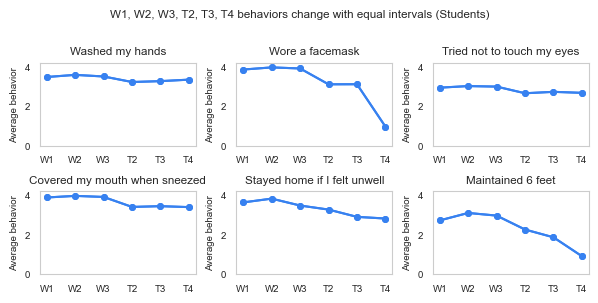

In [39]:
i = 1
j = 1

plt.rcParams.update({'font.size': 7})
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6, 3))
fig.suptitle('W1, W2, W3, T2, T3, T4 behaviors change with equal intervals (Students)')

for v in v_names[1:]:
    aux = avg_behavior[(avg_behavior['behavior'] == v) & 
                       (avg_behavior['cohort'] == 'Students')]
    axes[i - 1, j - 1].plot(['W1', 'W2', 'W3', 'T2', 'T3', 'T4'], 
                            [aux['W1'], aux['W2'], aux['W3'], aux['T2'], 
                             aux['T3'], aux['T4']], marker='o', 
                            linestyle='-', color="#3781f0", markersize=4)
    axes[i - 1, j - 1].plot(['W1', 'W2', 'W3', 'T2', 'T3', 'T4'], 
                            [aux['W1'], aux['W2'], aux['W3'], aux['T2'], 
                             aux['T3'], aux['T4']], marker='o', linestyle='-', 
                            color="#3781f0", markersize=4)
    axes[i - 1, j - 1].set_title(v)
    axes[i - 1, j - 1].set_ylim([0, 4.2])
    axes[i - 1, j - 1].set_ylabel('Average behavior')

    if j == 3:
        i += 1
        j = 1
    else:
        j += 1

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Non-students: Ridit

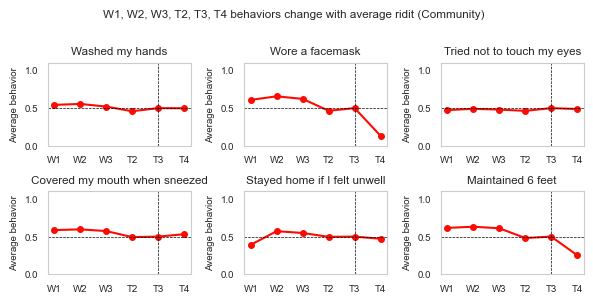

In [40]:
t1 = ridit.loc[ridit['Reference']=='2021-12-19 to 2022-04-29', ]

i = 1
j = 1

plt.rcParams.update({'font.size': 7})
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6, 3))
fig.suptitle('W1, W2, W3, T2, T3, T4 behaviors change with average ridit (Community)')

for v in v_names[1:]:
    aux = t1.loc[t1['Variable']== v, ['Period', 'Avg_ridit']]
    w1 = np.array(aux.loc[aux['Period']=='2020-06-01 to 2020-08-24', 'Avg_ridit'])[0]
    w2 = np.array(aux.loc[aux['Period']=='2020-08-24 to 2020-12-31', 'Avg_ridit'])[0]
    w3 = np.array(aux.loc[aux['Period']=='2021-01-01 to 2021-04-30', 'Avg_ridit'])[0]
    w41 = np.array(aux.loc[aux['Period']=='2021-05-01 to 2021-12-18', 'Avg_ridit'])[0]
    w42 = np.array(aux.loc[aux['Period']=='2021-12-19 to 2022-04-29', 'Avg_ridit'])[0]
    w5 = np.array(aux.loc[aux['Period']=='2022-08-01 to 2022-11-30', 'Avg_ridit'])[0]

    axes[i - 1, j - 1].plot(['W1', 'W2', 'W3', 'T2', 'T3', 'T4'], 
                            [w1, w2, w3, w41, w42, w5], marker='o', 
                            linestyle='-', color="#fc0b03", markersize=4)
    axes[i - 1, j - 1].axhline(y=0.5, color='black', linestyle='--', 
                               linewidth=0.5) 
    axes[i - 1, j - 1].axvline(x='T3', color='black', linestyle='--', 
                               linewidth=0.5)
    axes[i - 1, j - 1].set_title(v)
    axes[i - 1, j - 1].set_ylim([0, 1.1])
    axes[i - 1, j - 1].set_ylabel('Average behavior')

    if j == 3:
        i += 1
        j = 1
    else:
        j += 1

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Non-students: Equal interval

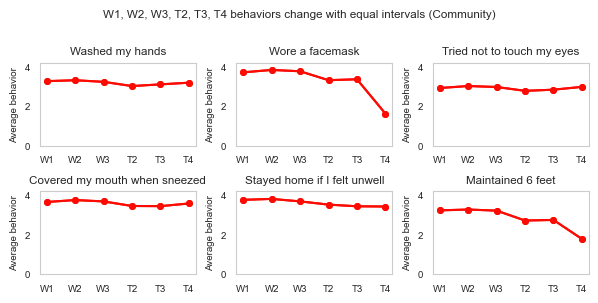

In [41]:
i = 1
j = 1

plt.rcParams.update({'font.size': 7})
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6, 3))
fig.suptitle('W1, W2, W3, T2, T3, T4 behaviors change with equal intervals (Community)')

for v in v_names[1:]:
    aux = avg_behavior[(avg_behavior['behavior'] == v) & 
                       (avg_behavior['cohort'] == 'Non-students')]
    axes[i - 1, j - 1].plot(['W1', 'W2', 'W3', 'T2', 'T3', 'T4'], 
                            [aux['W1'], aux['W2'], aux['W3'], aux['T2'], 
                             aux['T3'], aux['T4']], marker='o', 
                            linestyle='-', color="#fc0b03", markersize=4)
    axes[i - 1, j - 1].plot(['W1', 'W2', 'W3', 'T2', 'T3', 'T4'], 
                            [aux['W1'], aux['W2'], aux['W3'], aux['T2'], 
                             aux['T3'], aux['T4']], marker='o', linestyle='-', 
                            color="#fc0b03", markersize=4)
    axes[i - 1, j - 1].set_title(v)
    axes[i - 1, j - 1].set_ylim([0, 4.2])
    axes[i - 1, j - 1].set_ylabel('Average behavior')

    if j == 3:
        i += 1
        j = 1
    else:
        j += 1

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
